In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers
!pip install torch==1.5.1
!pip install tqdm
!pip install tensorboard
!pip install seqeval

In [3]:
import os
import sys
import json
from tqdm import tqdm
sys.path.append("/content/drive/MyDrive/MovieEntityRecognizer")

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import tensorboard
from seqeval.metrics import classification_report
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from transformers import (WEIGHTS_NAME, AdamW, BertConfig,
                                  BertForTokenClassification, BertTokenizer,
                                  get_linear_schedule_with_warmup)
from src.movientities.models.BertModel import BertNerModel
from src.movientities.data.analyze_dataset import Analyzer
from src.movientities.data.make_dataset import MakeData
from src.movientities.utils.processors import NerPreProcessor

<Figure size 432x288 with 0 Axes>

In [4]:
# Some initializers
train = True
num_train_epochs = 5
train_batch_size = 32
eval_batch_size = 8
# Weight decay for regularization
weight_decay = 0.01
# Now 1 but if batches wont fit RAM can be increased
gradient_accumulation_steps = 1
# %10 warm up
warmup_proportion = 0.1
# Adam variables
adam_epsilon = 1e-8
learning_rate = 5e-5
# 16 floating point instead of 32
fp16 = False
if fp16:
    # Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']
    fp16_opt_level
# max seq length (for engtrain.bio since the lengths are pretty short 128 is alright)
max_seq_length = 128
# For gradient clipping
max_grad_norm = 1.0
# For having flexibility over hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Data path
data_dir = "/content/drive/MyDrive/MovieEntityRecognizer/data/modified"
# Tensorboard Name
tensorboard_writer = tensorboard.SummaryWriter("bert_base_uncased_default")

validate = True
test = True

In [5]:
# For downloading data, doesn't require ssl so if downloaded no need to run it again
# dataset_names = ["engtrain.bio", "engtest.bio", "trivia10k13train.n,bio", "trivia10k13test.bio"]
# (MakeData.download_data(os.path.join("http://groups.csail.mit.edu/sls/downloads/movie", dataset_name) for dataset_name in dataset_names)



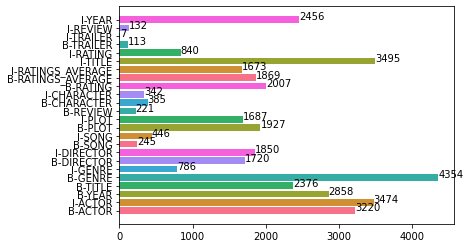

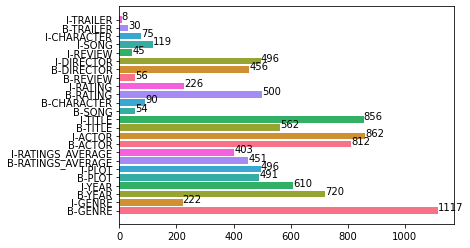

In [6]:
# Count also word frequencies and lengths or sentences
train_labels = Analyzer.count_labels("/content/drive/MyDrive/MovieEntityRecognizer/data/raw/engtrain.bio", without_o=True)
Analyzer.plot_data(train_labels)
test_labels = Analyzer.count_labels("/content/drive/MyDrive/MovieEntityRecognizer/data/raw/engtest.bio", without_o=True)
Analyzer.plot_data(test_labels)

In [7]:
# Get distinct labels
label_list = list(train_labels.keys())
# label_list.append("X")
label_list.append("[CLS]")
label_list.append("[SEP]")
label_list = ["O"] + label_list
num_labels = len(label_list) + 1
print(f"Size of labels of regular dataset: {len(label_list)}\n{label_list}")

Size of labels of regular dataset: 27
['O', 'B-ACTOR', 'I-ACTOR', 'B-YEAR', 'B-TITLE', 'B-GENRE', 'I-GENRE', 'B-DIRECTOR', 'I-DIRECTOR', 'B-SONG', 'I-SONG', 'B-PLOT', 'I-PLOT', 'B-REVIEW', 'B-CHARACTER', 'I-CHARACTER', 'B-RATING', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'I-TITLE', 'I-RATING', 'B-TRAILER', 'I-TRAILER', 'I-REVIEW', 'I-YEAR', '[CLS]', '[SEP]']


In [8]:
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_labels, finetuning_task="ner")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertNerModel.from_pretrained("bert-base-uncased",
              from_tf = False,
              config = config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertNerModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertNerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertNerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertNerModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 

In [9]:
if train:
    train_instances = NerPreProcessor.get_instances(data_dir, "train")
    num_train_optimization_steps = int(
    len(train_instances) / train_batch_size / gradient_accumulation_steps) * num_train_epochs
    print(f"Number of training steps {num_train_optimization_steps}")
    print(f"Number of training instances {len(train_instances)}")

if validate:
    val_instances = NerPreProcessor.get_instances(data_dir, "dev")
    val_steps = int(
    len(val_instances) / eval_batch_size)
    print(f"Number of val steps {val_steps}")
    print(f"Number of val instances {len(val_instances)}")

if test:
    test_instances = NerPreProcessor.get_instances(data_dir, "test")
    test_steps = int(
    len(test_instances) / eval_batch_size)
    print(f"Number of test steps {test_steps}")
    print(f"Number of test instances {len(test_instances)}")

Number of training steps 1525
Number of training instances 9775
Number of val steps 166
Number of val instances 1334
Number of test steps 138
Number of test instances 1109


In [10]:
# Pass the model to GPU if any and summary of the model
model.to(device)
print(f"Model is at device {device}")

Model is at device cuda


In [11]:
# Regularization to the weights with weight decay (which is L2 norm in this case)
param_optimizer = list(model.named_parameters())
# The shouldn't be a regularization to layer normalization and bias considering their natures.
no_decay = ['bias','LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

In [12]:
warmup_steps = int(warmup_proportion * num_train_optimization_steps)
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, num_train_optimization_steps)

In [13]:
# for 16 floating point training which will save RAM but may decrease performance, can be used if RAM is not enough
if fp16:
    try:
        from apex import amp
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
    model, optimizer = amp.initialize(model, optimizer, opt_level=fp16_opt_level)

In [14]:
if train:
    train_features = NerPreProcessor.convert_instances_to_features(
            train_instances, label_list, max_seq_length, tokenizer)

*** Example ***
guid: train-0
tokens: what movies star bruce willis
input_ids: 101 2054 5691 2732 5503 12688 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
*** Example ***
guid: train-1
tokens: show me films with drew barry ##more from the 1980s
input_ids: 101 226

In [15]:
if train:
    # Extract inputs for converting them to torch.long
    all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
    all_valid_ids = torch.tensor([f.valid_ids for f in train_features], dtype=torch.long)
    all_lmask_ids = torch.tensor([f.label_mask for f in train_features], dtype=torch.long)

In [16]:
if train:
    # Combine them back into tensor dataset
    train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids,all_valid_ids,all_lmask_ids)
    train_sampler = RandomSampler(train_data)

In [17]:
if validate:
    val_features = NerPreProcessor.convert_instances_to_features(
        val_instances, label_list, max_seq_length, tokenizer)

*** Example ***
guid: dev-0
tokens: are there any good romantic comedies out right now
input_ids: 101 2024 2045 2151 2204 6298 22092 2041 2157 2085 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
*** Example ***
guid: dev-1
tokens: show me a movie about cars that talk
inpu

In [18]:
if validate:
    # Extract inputs for converting them to torch.long
    val_all_input_ids = torch.tensor([f.input_ids for f in val_features], dtype=torch.long)
    val_all_input_mask = torch.tensor([f.input_mask for f in val_features], dtype=torch.long)
    val_all_segment_ids = torch.tensor([f.segment_ids for f in val_features], dtype=torch.long)
    val_all_label_ids = torch.tensor([f.label_id for f in val_features], dtype=torch.long)
    val_all_valid_ids = torch.tensor([f.valid_ids for f in val_features], dtype=torch.long)
    val_all_lmask_ids = torch.tensor([f.label_mask for f in val_features], dtype=torch.long)

In [19]:
if validate:
    # Combine them back into tensor dataset
    val_data = TensorDataset(val_all_input_ids, val_all_input_mask, val_all_segment_ids, val_all_label_ids,val_all_valid_ids,val_all_lmask_ids)
    val_sampler = SequentialSampler(val_data)

In [20]:
if train:
    # Initialize a DataLoader for putting batches to RAM and from RAM when backpropagation is finished
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)
if validate:
    # Same for validation
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=eval_batch_size)

In [21]:
if train:
    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0
    label_map = {i : label for i, label in enumerate(label_list, 1)}
    # Initialize training mode of the model for turning on regularizations such as dropout and L2
    model.train()
    for _ in range(int(num_train_epochs)):
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids, valid_ids,l_mask = batch
            loss = model(input_ids, segment_ids, input_mask, label_ids,valid_ids,l_mask)
            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps
            
            if fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), max_grad_norm)
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1
            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
            tensorboard_writer.add_scalar("Loss/train", loss, global_step)
        if validate:
            model.eval()
            eval_loss, eval_accuracy = 0, 0
            nb_eval_steps, nb_eval_examples = 0, 0
            y_true = []
            y_pred = []
            label_map = {i : label for i, label in enumerate(label_list,1)}
            for input_ids, input_mask, segment_ids, label_ids,valid_ids,l_mask in tqdm(val_dataloader, desc="Evaluating"):
                input_ids = input_ids.to(device)
                input_mask = input_mask.to(device)
                segment_ids = segment_ids.to(device)
                valid_ids = valid_ids.to(device)
                label_ids = label_ids.to(device)
                l_mask = l_mask.to(device)

                with torch.no_grad():
                    logits = model(input_ids, segment_ids, input_mask,valid_ids=valid_ids,attention_mask_label=l_mask)

                logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
                logits = logits.detach().cpu().numpy()
                label_ids = label_ids.to('cpu').numpy()
                input_mask = input_mask.to('cpu').numpy()
                for i, label in enumerate(label_ids):
                    temp_1 = []
                    temp_2 = []
                    for j,m in enumerate(label):
                        if j == 0 or label_ids[i][j] == 0 or logits[i][j] == 0:
                            continue
                        elif label_ids[i][j] == len(label_map):
                            y_true.append(temp_1)
                            y_pred.append(temp_2)
                            break
                        else:
                            temp_1.append(label_map[label_ids[i][j]])
                            temp_2.append(label_map[logits[i][j]])
            report = classification_report(y_true, y_pred,digits=4)
            print("\n%s", report)
        model.save_pretrained(f"/content/drive/MyDrive/MovieEntityRecognizer/pretrained_models/bert_base_uncased/modelb32defaulte{_}.pt")
        tokenizer.save_pretrained(f"/content/drive/MyDrive/MovieEntityRecognizer/pretrained_models/bert_base_uncased")
        label_map = {i : label for i, label in enumerate(label_list,1)}
        model_config = {"bert_model":"bert-base-cased","do_lower":False,"max_seq_length":max_seq_length,"num_labels":len(label_list)+1,"label_map":label_map}
        json.dump(model_config,open(os.path.join("/content/drive/MyDrive/MovieEntityRecognizer/pretrained_models/bert_base_uncased","model_config.json"),"w"))

Evaluating: 100%|██████████| 167/167 [00:13<00:00, 12.22it/s]



%s                  precision    recall  f1-score   support

          ACTOR     0.8650    0.8981    0.8812       471
      CHARACTER     0.4844    0.3974    0.4366        78
       DIRECTOR     0.8104    0.8261    0.8182       207
          GENRE     0.7674    0.8506    0.8069       415
           PLOT     0.5164    0.5318    0.5240       267
         RATING     0.8217    0.7963    0.8088       162
RATINGS_AVERAGE     0.6357    0.7009    0.6667       117
         REVIEW     0.0000    0.0000    0.0000        50
           SONG     0.6667    0.4800    0.5581        50
          TITLE     0.7942    0.8674    0.8292       347
        TRAILER     0.7391    0.8500    0.7907        20
           YEAR     0.9164    0.8660    0.8905       291

      micro avg     0.7697    0.7778    0.7737      2475
      macro avg     0.6681    0.6721    0.6676      2475
   weighted avg     0.7544    0.7778    0.7648      2475



Evaluating: 100%|██████████| 167/167 [00:13<00:00, 12.20it/s]



%s                  precision    recall  f1-score   support

          ACTOR     0.8678    0.8917    0.8796       471
      CHARACTER     0.5942    0.5256    0.5578        78
       DIRECTOR     0.8302    0.8502    0.8401       207
          GENRE     0.8128    0.8578    0.8347       415
           PLOT     0.5430    0.5918    0.5663       267
         RATING     0.7987    0.7840    0.7913       162
RATINGS_AVERAGE     0.6990    0.6154    0.6545       117
         REVIEW     0.1818    0.0400    0.0656        50
           SONG     0.5833    0.5600    0.5714        50
          TITLE     0.7700    0.8876    0.8246       347
        TRAILER     0.7500    0.9000    0.8182        20
           YEAR     0.9167    0.8694    0.8924       291

      micro avg     0.7789    0.7915    0.7852      2475
      macro avg     0.6956    0.6978    0.6914      2475
   weighted avg     0.7707    0.7915    0.7790      2475



Evaluating: 100%|██████████| 167/167 [00:13<00:00, 12.15it/s]



%s                  precision    recall  f1-score   support

          ACTOR     0.8935    0.9087    0.9011       471
      CHARACTER     0.6615    0.5513    0.6014        78
       DIRECTOR     0.8396    0.8599    0.8496       207
          GENRE     0.8152    0.8506    0.8325       415
           PLOT     0.5170    0.5693    0.5419       267
         RATING     0.8250    0.8148    0.8199       162
RATINGS_AVERAGE     0.6695    0.6752    0.6723       117
         REVIEW     0.3429    0.2400    0.2824        50
           SONG     0.6444    0.5800    0.6105        50
          TITLE     0.8059    0.8732    0.8382       347
        TRAILER     0.7500    0.9000    0.8182        20
           YEAR     0.8763    0.9003    0.8881       291

      micro avg     0.7831    0.8036    0.7932      2475
      macro avg     0.7201    0.7269    0.7213      2475
   weighted avg     0.7812    0.8036    0.7916      2475



Evaluating: 100%|██████████| 167/167 [00:13<00:00, 12.16it/s]



%s                  precision    recall  f1-score   support

          ACTOR     0.8877    0.9066    0.8971       471
      CHARACTER     0.6111    0.5641    0.5867        78
       DIRECTOR     0.8592    0.8551    0.8571       207
          GENRE     0.8023    0.8410    0.8212       415
           PLOT     0.5278    0.5693    0.5477       267
         RATING     0.8313    0.8210    0.8261       162
RATINGS_AVERAGE     0.7217    0.7094    0.7155       117
         REVIEW     0.2667    0.1600    0.2000        50
           SONG     0.5714    0.5600    0.5657        50
          TITLE     0.8000    0.8646    0.8310       347
        TRAILER     0.7500    0.9000    0.8182        20
           YEAR     0.9211    0.8832    0.9018       291

      micro avg     0.7860    0.7984    0.7921      2475
      macro avg     0.7125    0.7195    0.7140      2475
   weighted avg     0.7835    0.7984    0.7902      2475



Evaluating: 100%|██████████| 167/167 [00:13<00:00, 12.09it/s]



%s                  precision    recall  f1-score   support

          ACTOR     0.8893    0.9214    0.9051       471
      CHARACTER     0.6000    0.5769    0.5882        78
       DIRECTOR     0.8929    0.8454    0.8685       207
          GENRE     0.8212    0.8410    0.8310       415
           PLOT     0.5034    0.5506    0.5259       267
         RATING     0.8037    0.8086    0.8062       162
RATINGS_AVERAGE     0.6903    0.6667    0.6783       117
         REVIEW     0.2222    0.1600    0.1860        50
           SONG     0.5745    0.5400    0.5567        50
          TITLE     0.8139    0.8444    0.8289       347
        TRAILER     0.7143    0.7500    0.7317        20
           YEAR     0.9173    0.8763    0.8963       291

      micro avg     0.7847    0.7907    0.7877      2475
      macro avg     0.7036    0.6984    0.7002      2475
   weighted avg     0.7839    0.7907    0.7868      2475

